In [1]:
%matplotlib inline
import numpy as np
import numpy.random as random
import firedrake
from firedrake import inner, grad, div, dx, ds

In [2]:
Nx, Ny = 64, 64
mesh = firedrake.UnitSquareMesh(Nx, Ny)
p = 2
Q = firedrake.FunctionSpace(mesh, 'CG', p)

To come up with some boundary data, we'll use a random trigonometric polynomial.

In [3]:
x, y = firedrake.SpatialCoordinate(mesh)

from numpy import pi as π
def random_trig_poly(degree):
    a = random.normal(0, 1, (degree, degree))
    b = random.normal(0, 1, (degree, degree))
    for k in range(degree):
        for l in range(degree):
            a[k, l] /= np.sqrt(1 + k**2 + l**2)
            b[k, l] /= np.sqrt(1 + k**2 + l**2)

    expr = sum([a[k, l] * firedrake.sin(π*(k*x + l*y)) + b[k, l] * firedrake.cos(π*(k*x + l*y))
                for k in range(degree)
                for l in range(degree) if k**2 + l**2 <= degree**2])
                
    return expr

degree = 5
g = firedrake.interpolate(random_trig_poly(degree), Q)

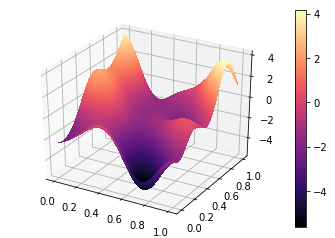

In [4]:
firedrake.plot(g, cmap='magma', plot3d=True)

### Traditional method for Dirichlet BCs

In [5]:
def laplace_solve(g):
    u = g.copy(deepcopy=True)
    J = 0.5 * inner(grad(u), grad(u)) * dx
    bc = firedrake.DirichletBC(Q, g, 'on_boundary')
    firedrake.solve(firedrake.derivative(J, u) == 0, u, bc,
                    solver_parameters={'ksp_type': 'preonly', 'pc_type': 'lu'})
    return u

In [6]:
u = laplace_solve(g)

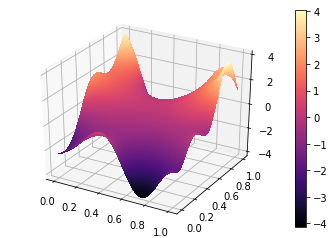

In [7]:
firedrake.plot(u, cmap='magma', plot3d=True)

### Nitsche's method

In [8]:
def laplace_solve_nitsche(g, η):
    ν = firedrake.FacetNormal(mesh)
    h = firedrake.CellSize(mesh)
    
    u = g.copy(deepcopy=True)
    J_internal = 0.5 * inner(grad(u), grad(u)) * dx
    J_lagrange = inner(grad(u), ν) * (u - g) * ds
    J_penalty = 0.5 * η / h * (u - g)**2 * ds
    J = J_internal - J_lagrange + J_penalty
    
    firedrake.solve(firedrake.derivative(J, u) == 0, u,
                    solver_parameters={'ksp_type': 'preonly', 'pc_type': 'lu'})
    return u

In [9]:
import mesh_util
θ = mesh_util.minimum_angle(mesh)
d = 2
η = 4 * p * (p + d - 1) / np.cos(θ) / np.tan(θ/2)

v = laplace_solve_nitsche(g, η)

I can't explain that blip at the corners but even that doesn't make a difference in the eyeball norm.

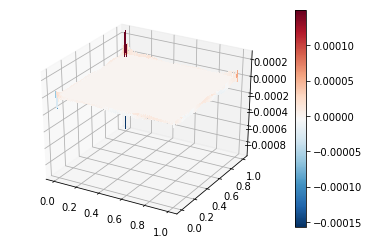

In [10]:
error_nitsche = firedrake.interpolate(u - v, Q)
firedrake.plot(error_nitsche, cmap='RdBu_r', plot3d=True)

The difference is on the order of the interpolation error for a mesh this size and 2nd-order finite elements.

In [11]:
firedrake.norm(error_nitsche)

4.7382955619797345e-06

### Penalty method

In [12]:
def laplace_solve_penalty(g, η):
    h = firedrake.CellSize(mesh)
    
    u = g.copy(deepcopy=True)
    J_internal = 0.5 * inner(grad(u), grad(u)) * dx
    J_penalty = 0.5 * η / h * (u - g)**2 * ds
    J = J_internal + J_penalty

    firedrake.solve(firedrake.derivative(J, u) == 0, u,
                    solver_parameters={'ksp_type': 'preonly', 'pc_type': 'lu'})
    return u

The penalty parameter must be an order of magnitude higher than in Nitsche's method to get a comparable error.

In [13]:
w = laplace_solve_penalty(g, 250 * η)

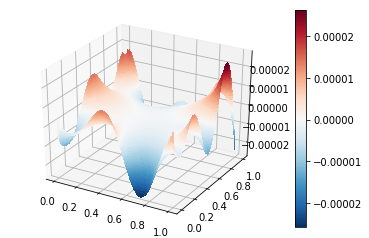

In [14]:
error_penalty = firedrake.interpolate(u - w, Q)
firedrake.plot(error_penalty, cmap='RdBu_r', plot3d=True)

In [15]:
firedrake.norm(error_penalty)

5.485396380414748e-06

### Increasing the penalty parameter in Nitsche's method

In [16]:
ηs = 2 * p * (p + d - 1) / np.cos(θ) / np.tan(θ/2) * np.logspace(0, 16, 16, base=1.5)
errors = np.zeros(np.shape(ηs))
for i, η in enumerate(ηs):
    v = laplace_solve_nitsche(g, η)
    errors[i] = firedrake.norm(u - v)

Increasing the penalty parameter reduces the error in Nitsche's method.
The advantages over the penalty method are:
* Much less penalization necessary to achieve the same error with a fixed discretization
* Achieves optimal order convergence as the mesh is refined or the polynomial order is increased

In [17]:
slope, intercept = np.polyfit(np.log10(ηs), np.log10(errors), 1)
print(slope, intercept)

-0.9541011312851361 -3.485938135097153


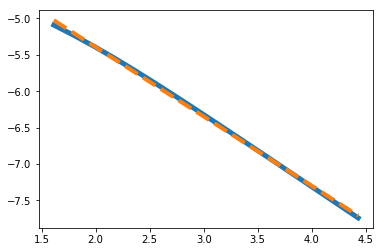

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(np.log10(ηs), np.log10(errors), linewidth=5)
ax.plot(np.log10(ηs), intercept + slope * np.log10(ηs), '--', linewidth=4)